In [15]:
import numpy as np
import matplotlib.pyplot as plt
from tsmoothie.smoother import GaussianSmoother
import spikeinterface
import spikeinterface.full as si
import spikeinterface.extractors as se
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
import spikeinterface.postprocessing as sp
import spikeinterface.preprocessing as spre
import spikeinterface.qualitymetrics as qm
import helper_functions as helper
from spikeinterface.sorters import run_sorter_local

In [54]:
#Reading the file, BP filtering
#path of the network file
local_path= '/mnt/disk20tb/PrimaryNeuronData/Maxtwo/Folic_Acid_T2/Folic_Acid_T2/240123/M05506/ActivityScan/000001/data.raw.h5' #network data from chip 16848

recordings = list()
#recording1=se.read_maxwell(local_path,stream_id='well000',rec_name='rec0000')

for recname in ['rec0000', 'rec0001', 'rec0002', 'rec0003', 'rec0004', 'rec0005', 'rec0006']:
    recordings.append(se.read_maxwell(local_path,stream_id='well000',rec_name=recname)) #well000 - well005 for maxtwo 
recording1 = si.aggregate_channels(recordings)


#recording = si.ConcatenateSegmentRecording([recording1,recording2])
channel_ids = recording1.get_channel_ids()
fs = recording1.get_sampling_frequency()
num_chan = recording1.get_num_channels()
num_seg = recording1.get_num_segments()
total_recording = recording1.get_total_duration()

#print('Channel ids:', channel_ids)
print('Sampling frequency:', fs)
print('Number of channels:', num_chan)
print('Number of segments:', num_seg)
print(f"total_recording: {total_recording} s")

recording_bp = spre.bandpass_filter(recording1, freq_min=300, freq_max=3000)

recodring_cmr = spre.common_reference(recording_bp, reference='global', operator='median')
#recording_chunk = recodring_cmr.frame_slice(start_frame= 1*fs,end_frame=425*fs)
recording_chunk = recodring_cmr.frame_slice(start_frame= 0*fs,end_frame=30*fs)
print(f"chunk duration: {recording_chunk.get_total_duration()} s")

Sampling frequency: 10000.0
Number of channels: 6600
Number of segments: 1
total_recording: 30.02 s
chunk duration: 30.0 s


## RUnnig sorting

In [18]:
traces = recording_chunk.get_traces(start_frame=100, end_frame=50000*15, segment_index=0,return_scaled=True)


KeyboardInterrupt: 

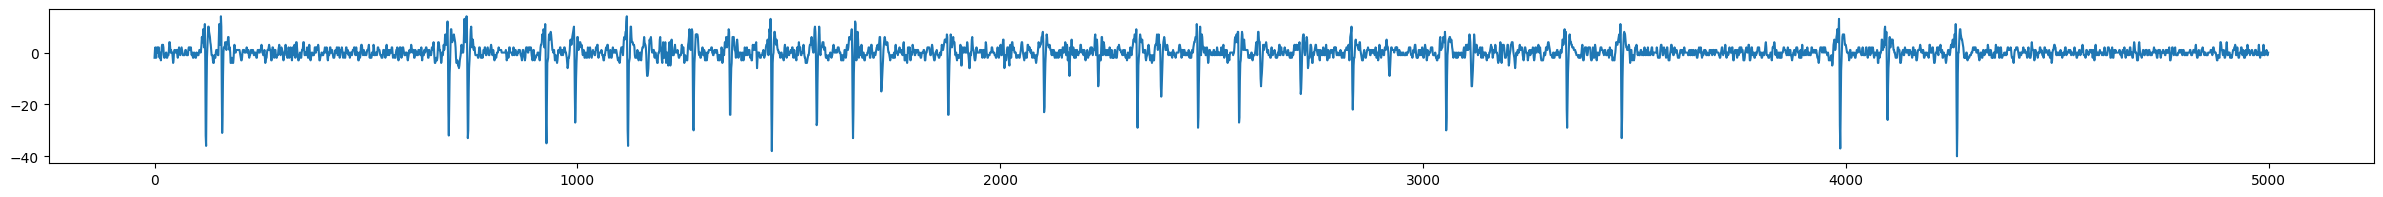

In [48]:
traces = recording_chunk.get_traces(start_frame=306000, end_frame=311000, segment_index=0,return_scaled=False)
plt.figure(figsize=(30,2))
plt.plot(traces[:,701])
plt.savefig('/home/mmp/Documents/traces/fulltrace_wt.svg',format='svg',dpi=600)
plt.show()

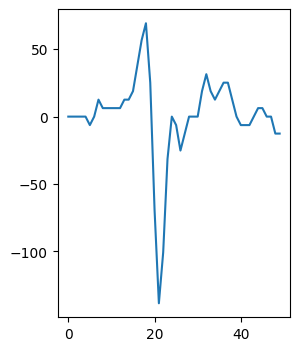

In [70]:
traces = recording_chunk.get_traces(start_frame=278860, end_frame=278910, segment_index=0,return_scaled=True)
plt.figure(figsize=(3,4))
plt.plot(traces[:,500])
plt.savefig('/home/mmp/Documents/traces/zoomedin.svg',format='svg')
plt.show()

In [55]:
default_KS2_params = ss.get_default_sorter_params('kilosort2')
print(default_KS2_params)
# default_KS2_params['keep_good_only'] = True
# default_KS2_params['detect_threshold'] = 12
# default_KS2_params['projection_threshold']=[18, 10]
# default_KS2_params['preclust_threshold'] = 8
run_sorter = ss.run_sorter('kilosort2',recording=recording_chunk, output_folder="./sorting/aggrgated_channels", docker_image= "rohanmalige/rohan_si-100:v1",verbose=True, **default_KS2_params)

## if running on NERSC:
#run_sorter_local("kilosort2",recording_chunk, output_folder="./sorting/FolicAcid10mg", delete_output_folder=False,verbose=True,with_output=True,**default_KS2_params)
#run_sorter = ss.run_sorter('kilosort2',recording= recording_chunk, output_folder="/mnt/disk15tb/mmpatil/Spikesorting/sorter_output/kilosort2",docker_image= True,verbose=True, **default_KS2_params)

{'detect_threshold': 6, 'projection_threshold': [10, 4], 'preclust_threshold': 8, 'momentum': [20.0, 400.0], 'car': True, 'minFR': 0.1, 'minfr_goodchannels': 0.1, 'freq_min': 150, 'sigmaMask': 30, 'lam': 10.0, 'nPCs': 3, 'ntbuff': 64, 'nfilt_factor': 4, 'NT': None, 'AUCsplit': 0.9, 'wave_length': 61, 'keep_good_only': False, 'skip_kilosort_preprocessing': False, 'scaleproc': None, 'save_rez_to_mat': False, 'delete_tmp_files': ('matlab_files',), 'delete_recording_dat': False, 'n_jobs': 48, 'chunk_duration': '1s', 'progress_bar': True, 'mp_context': None, 'max_threads_per_process': 1}
installation_mode='auto' switching to installation_mode: 'github'
Starting container
Running kilosort2 sorter inside rohanmalige/rohan_si-100:v1


In [67]:

# loading the KS2 sorted object
sortingKS3 = run_sorter.remove_empty_units()
sortingKS3 = spikeinterface.curation.remove_excess_spikes(sortingKS3,recording_chunk) #Sometimes KS returns spikes outside the number of samples. < https://github.com/SpikeInterface/spikeinterface/pull/1378>

sortingKS3= sortingKS3.save(folder = './sorting/RETT_organoid_16876_KS2')
#sorting_KS3 = s.Kilosort2Sorter._get_result_from_folder('./sorting/FolicAcidT2M07038_2_KS/sorter_output')
total_units = sortingKS3.get_unit_ids()
print(len(total_units))
#print(len(total_units))
channel_ids = recording_chunk.get_channel_ids()
print(channel_ids)

230
['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15'
 '16' '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29'
 '30' '31' '32' '33' '34' '35' '36' '37' '38' '39' '40' '41' '42' '43'
 '44' '45' '46' '47' '48' '49' '50' '51' '52' '53' '54' '55' '56' '57'
 '58' '59' '60' '61' '62' '63' '64' '65' '66' '67' '68' '69' '70' '71'
 '72' '73' '74' '75' '76' '77' '78' '79' '80' '81' '82' '83' '84' '85'
 '86' '87' '88' '89' '90' '91' '92' '93' '94' '95' '96' '97' '98' '99'
 '100' '101' '102' '103' '104' '105' '106' '107' '108' '109' '110' '111'
 '112' '113' '114' '115' '116' '117' '118' '119' '120' '121' '122' '123'
 '124' '125' '126' '127' '128' '129' '130' '131' '132' '133' '134' '135'
 '136' '137' '138' '139' '140' '141' '142' '143' '144' '145' '146' '147'
 '148' '149' '150' '151' '152' '153' '154' '155' '156' '157' '158' '159'
 '160' '161' '162' '163' '164' '165' '166' '167' '168' '169' '170' '171'
 '172' '173' '174' '175' '176' '177' '178' '179' '180' '181' 

/home/mmp/.local/lib/python3.10/site-packages/spikeinterface/core/basesorting.py:239: UserWarning: The registered recording will not be persistent on disk, but only available in memory
  warnings.warn("The registered recording will not be persistent on disk, but only available in memory")


## Extracting the waveforms

In [68]:

job_kwargs = dict(n_jobs=32, chunk_duration="1s", progress_bar=True)
#waveforms = si.extract_waveforms(recording_chunk,sorting_KS3,folder="./waveformsblock1_7min",overwrite=True, ms_before=1., ms_after=2.,**job_kwargs)
waveforms = si.extract_waveforms(recording_chunk,sortingKS3,folder='./sorting/RETT_organoid_16876_waveforms',overwrite=True,**job_kwargs)
print(waveforms)

extract waveforms shared_memory multi buffer:   0%|          | 0/180 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/180 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/180 [00:00<?, ?it/s]

WaveformExtractor: 996 channels - 230 units - 1 segments
  before:20 after:40 n_per_units:500 - sparse


In [1]:
print('hello')

hello


In [ ]:
sorter = si.sorters._get_res

In [6]:
waveforms = si.load_waveforms('/mnt/disk15tb/adam/git_workspace/MEA_Analysis/AxonReconPipeline/data/temp_data/waveforms/240118/M06844/AxonTracking/000026/well001/waveforms/',with_recording=False)

ValueError: This WaveformExtractor folder was created with an older version of spikeinterface
You cannot use the mode with_recording=False

In [69]:
si.export_to_phy(waveform_extractor=waveforms,output_folder='./sorting/RETT_organoid_16876_phy',**job_kwargs)

write_binary_recording:   0%|          | 0/180 [00:00<?, ?it/s]

extract amplitudes:   0%|          | 0/180 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/230 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/230 [00:00<?, ?it/s]

extract PCs:   0%|          | 0/180 [00:00<?, ?it/s]

Run:
phy template-gui  /mnt/disk15tb/mmpatil/MEA_Analysis/IPNAnalysis/sorting/RETT_organoid_16876_phy/params.py


In [70]:
extremum_channels_ids =si.get_template_extremum_channel(waveforms,peak_sign ='both',mode='at_index')

In [71]:
template = waveforms.get_template(5,mode='median')
template.shape

(60, 18)

In [72]:

job_kwargs = dict(n_jobs=16, chunk_duration="1s", progress_bar=True)
sp.compute_spike_amplitudes(waveforms,load_if_exists=True,**job_kwargs)
metrics = qm.compute_quality_metrics(waveforms,load_if_exists=False,**job_kwargs)

/home/mmp/.local/lib/python3.10/site-packages/spikeinterface/qualitymetrics/misc_metrics.py:1221: UserWarning: Amplitude PDF does not have a unique minimum! More spikes might be required for a correct amplitude_cutoff computation!
  warnings.warn(
/home/mmp/.local/lib/python3.10/site-packages/spikeinterface/qualitymetrics/misc_metrics.py:848: UserWarning: Units [2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 17, 18, 20, 23, 24, 26, 29, 31, 32, 35, 36, 37, 40, 41, 42, 46, 47, 49, 50, 51, 52, 53, 54, 55, 57, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 74, 76, 77, 78, 82, 83, 84, 85, 87, 88, 89, 90, 91, 92, 94, 97, 98, 103, 104, 105, 106, 107, 108, 109, 111, 112, 114, 115, 116, 117, 120, 122, 123, 124, 125, 127, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 141, 143, 144, 149, 150, 151, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 167, 168, 169, 170, 171, 172, 174, 175, 177, 181, 182, 185, 186, 187, 190, 191, 193, 194, 196, 197, 198, 199, 203, 204, 205, 208, 209, 210, 212, 213, 214, 

  0%|          | 0/230 [00:00<?, ?it/s]

/home/mmp/.local/lib/python3.10/site-packages/spikeinterface/qualitymetrics/pca_metrics.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice
  VI = np.linalg.inv(np.cov(pcs_for_this_unit.T))
/home/mmp/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/mmp/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/mmp/.local/lib/python3.10/site-packages/spikeinterface/qualitymetrics/pca_metrics.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice
  VI = np.linalg.inv(np.cov(pcs_for_this_unit.T))
/home/mmp/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/mmp/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encounter

In [73]:
display(metrics)

,amplitude_cutoff,amplitude_cv_median,amplitude_cv_range,amplitude_median,firing_range,firing_rate,isi_violations_ratio,isi_violations_count,num_spikes,presence_ratio,...,snr,sync_spike_2,sync_spike_4,sync_spike_8,d_prime,isolation_distance,l_ratio,silhouette,nn_hit_rate,nn_miss_rate
2,NaN,NaN,NaN,188.827515,0.75,0.200000,0.000000,0.0,36.0,0.666667,...,19.485260,0.305556,0.000000,0.0,8.051448,4.111621e+15,NaN,0.390869,0.798611,0.002859
3,0.111070,0.205898,0.089645,31.471252,9.40,3.805556,0.383611,3.0,685.0,1.000000,...,inf,0.140146,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,18.882751,3.90,2.361111,0.664360,2.0,425.0,1.000000,...,2.205976,0.089412,0.000000,0.0,2.579497,7.794434e+01,0.489470,0.065355,0.534706,0.082265
5,NaN,NaN,NaN,31.471252,6.70,1.788889,50.923961,88.0,322.0,1.000000,...,2.987026,0.232919,0.003106,0.0,8.483622,2.187090e+02,0.000838,0.079625,0.333075,0.001374
6,NaN,NaN,NaN,69.236755,3.20,1.277778,0.000000,0.0,230.0,1.000000,...,7.466300,0.334783,0.013043,0.0,8.531018,6.112089e+02,0.018635,0.114556,0.871739,0.022306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,NaN,NaN,NaN,12.588501,4.05,1.677778,1.315732,2.0,302.0,1.000000,...,1.114471,0.102649,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN
243,NaN,NaN,NaN,18.882751,3.65,1.505556,4.901894,6.0,271.0,1.000000,...,inf,0.173432,0.000000,0.0,2.401139,1.083300e+02,0.582101,0.015986,0.140221,0.011869
244,0.019193,0.374915,0.128513,12.588501,9.55,4.783333,0.000000,0.0,861.0,1.000000,...,1.496018,0.082462,0.002323,0.0,4.120534,1.701023e+02,0.220279,0.014447,0.413000,0.007576
245,NaN,NaN,NaN,18.882751,4.05,1.644444,0.684806,1.0,296.0,1.000000,...,inf,0.246622,0.003378,0.0,2.879367,6.517055e+01,0.367859,0.057058,0.349662,0.057201


In [74]:
import mea_analysis_pipeline as msp

In [75]:
import importlib
importlib.reload(msp)
update_qual_metrics = msp.remove_violated_units(metrics)
non_violated_units  = update_qual_metrics.index.values

In [76]:
print(len(non_violated_units))

102


In [77]:
units_location_info = {unit_id: location for unit_id, location in zip(waveforms.unit_ids, si.compute_unit_locations(waveforms))}



In [78]:
print(units_location_info)

{2: array([2.88416350e+03, 8.91451784e+02, 2.27382133e+00]), 3: array([4.73777283e+01, 1.06317901e+03, 1.06120838e+00]), 4: array([ 78.39834354, 956.24562632,   1.62597047]), 5: array([3.04284107e+03, 1.17139693e+03, 1.52921202e+00]), 6: array([-16.4061341 , 792.58138342,   1.25256172]), 7: array([ 83.02338755, 754.7811818 ,   1.02561723]), 8: array([3.60500044e+03, 1.17316693e+03, 3.46952601e+00]), 9: array([3605.        , 1173.92448759,    3.99948914]), 10: array([3.72705528e+03, 1.20823731e+03, 2.66917847e+00]), 11: array([3.81902958e+03, 6.40457447e+02, 1.50512198e+00]), 12: array([1151.50537629, 1104.20610228,   24.62991997]), 13: array([1152.86716273, 1098.05448538,   17.62573999]), 14: array([1160.64584021, 1096.07050683,   32.20931845]), 15: array([3.12245417e+03, 1.24013701e+03, 1.00000000e+00]), 16: array([3.12186557e+03, 1.09895859e+03, 1.39565818e+00]), 17: array([247.00934146, 860.97009032,   5.8250559 ]), 18: array([2.93561698e+03, 8.18240628e+02, 1.63444097e+00]), 20: ar

<Figure size 1200x800 with 0 Axes>

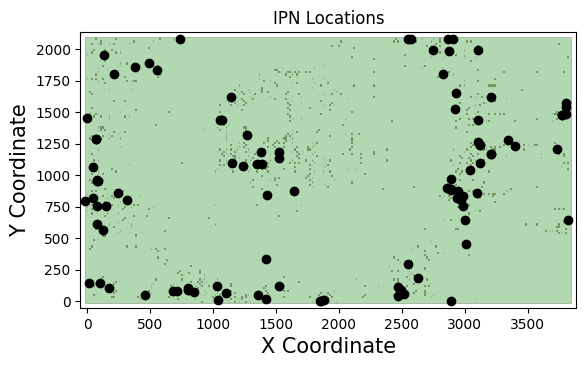

In [83]:
import pickle

plt.figure(figsize=(12, 8))
# try:
#     with open('/mnt/disk15tb/mmpatil/MEA_Analysis/IPNAnalysis/network_1020.pkl', 'rb') as file:
#         loaded_units_info = pickle.load(file)
# except EOFError as e:
#     print("Error loading the file:", e)
#     loaded_units_info = {}
loaded_units_info = {}
# Check if loaded_units_info is not empty
if loaded_units_info:
    # Extract x and y coordinates from the loaded dictionary
    x_coords_loaded = [location[0] for location in loaded_units_info.values()]
    y_coords_loaded = [location[1] for location in loaded_units_info.values()]

    # Plotting
      # Adjusts the figure size
    plt.scatter(x_coords_loaded, y_coords_loaded, marker='o',label='Network-1020')  # Uses red for distinct visualization

# Filter units_info to include only those units present in non_violated_units
filtered_units_info = {unit_id: units_location_info[unit_id] for unit_id in non_violated_units if unit_id in units_location_info}
# Save the filtered units info as a JSON file

# Extract x and y coordinates from the filtered dictionary
x_coords = [location[0] for location in filtered_units_info.values()]
y_coords = [location[1] for location in filtered_units_info.values()]

# Plotting
 # Adjusts the figure size
sw.plot_probe_map(recording_chunk,with_channel_ids=False)
plt.scatter(x_coords, y_coords, marker='o',color ='black',label='Neuronal_units')  # Plots the locations as points

# Optional: Enhancements for readability
plt.title('IPN Locations')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
#plt.legend()
plt.savefig("./network_comparison_combined.png",format='png')
#plt.grid(True)  # Adds a grid for easier visualization

plt.show()

In [13]:
job_kwargs = dict(n_jobs=48, chunk_duration="1s", progress_bar=True)
sparsity = spikeinterface.core.compute_sparsity(waveforms ,method="radius", radius_um=40)
export_to_phy(waveform_extractor=waveforms, output_folder='/mnt/disk15tb/mmpatil/MEA_Analysis/IPNAnalysis/sorting/M07038_phy',sparsity=sparsity,**job_kwargs)

write_binary_recording:   0%|          | 0/180 [00:00<?, ?it/s]

extract PCs:   0%|          | 0/180 [00:00<?, ?it/s]

Run:
phy template-gui  /mnt/disk15tb/mmpatil/MEA_Analysis/IPNAnalysis/sorting/M07038_phy/params.py


In [83]:
display(update_qual_metrics)

,num_spikes,firing_rate,presence_ratio,snr,isi_violations_ratio,isi_violations_count,rp_contamination,rp_violations,sliding_rp_violation,amplitude_cutoff,amplitude_median
0,713.0,3.961111,1.0,inf,0.0,0.0,0.0,0.0,0.045,0.030143,44.059753
1,815.0,4.527778,1.0,inf,0.0,0.0,0.0,0.0,0.035,0.005110,50.354004
9,1201.0,6.672222,1.0,inf,0.0,0.0,0.0,0.0,0.015,0.007593,182.533264
10,1300.0,7.222222,1.0,inf,0.0,0.0,0.0,0.0,0.015,0.006564,56.648254
13,1960.0,10.888889,1.0,inf,0.0,0.0,0.0,0.0,0.010,0.001716,37.765503
...,...,...,...,...,...,...,...,...,...,...,...
1076,742.0,4.122222,1.0,inf,0.0,0.0,0.0,0.0,0.105,0.005122,81.825256
1077,784.0,4.355556,1.0,inf,0.0,0.0,0.0,0.0,0.035,0.001359,107.002258
1078,877.0,4.872222,1.0,inf,0.0,0.0,0.0,0.0,0.080,0.032251,56.648254
1079,1178.0,6.544444,1.0,inf,0.0,0.0,0.0,0.0,0.025,0.016931,59.795380


In [7]:
print(non_violated_units)

[   0    1    9   10   13   14   19   26   27   29   34   41   47   48
   50   52   54   55   56   57   60   61   62   66   69   70   71   76
   77   83   84   85   90   91   92   93   96   97  101  103  104  105
  106  107  116  117  119  120  123  126  133  138  140  141  142  143
  149  154  157  158  159  160  164  165  166  175  178  181  182  187
  190  198  202  210  211  216  217  221  222  224  226  230  231  232
  233  234  239  240  242  243  249  252  254  257  259  262  280  293
  294  297  303  304  309  310  311  313  315  319  320  322  323  329
  330  331  333  334  335  338  351  354  355  358  359  366  371  373
  374  379  380  381  395  396  397  400  408  409  413  415  417  419
  421  422  423  428  431  435  436  438  439  446  453  459  465  470
  472  474  480  485  486  489  490  493  494  499  500  509  514  517
  523  524  525  531  537  540  541  542  546  547  552  554  556  557
  558  562  569  570  576  577  578  583  585  586  592  595  600  602
  604 

In [85]:
len(non_violated_units)

380

In [8]:
waveform_good = waveforms.select_units(non_violated_units,new_folder='./sorting/FolicAcidT2M07038_2_waveformsgood/')

In [9]:
correlograms, bins = sp.compute_correlograms(waveform_good)

In [23]:
correlograms.shape

(380, 380, 20)

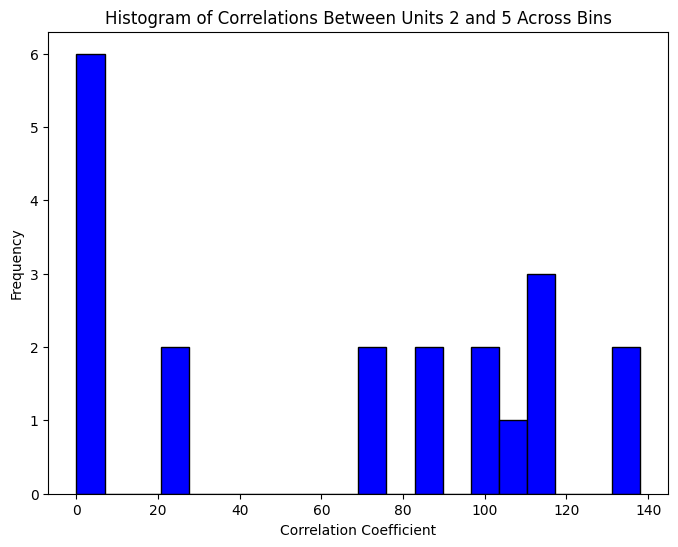

In [22]:
import matplotlib.pyplot as plt

# Extracting the correlation values between units 2 and 5 across all bins
# Adjusting indices for 0-based Python indexing
correlations = correlograms[2, 2, :]

# Plotting the histogram
plt.figure(figsize=(8, 6))
plt.hist(correlations, bins=20, color='blue', edgecolor='black')
plt.title('Histogram of Correlations Between Units 2 and 5 Across Bins')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency')
plt.show()

In [12]:
bins

array([-50., -45., -40., -35., -30., -25., -20., -15., -10.,  -5.,   0.,
         5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.])

In [10]:
metrics = qm.compute_quality_metrics(waveform_good,load_if_exists=False,**job_kwargs)

/home/mmp/.local/lib/python3.10/site-packages/spikeinterface/qualitymetrics/misc_metrics.py:232: RuntimeWarning: divide by zero encountered in scalar divide
  snrs[unit_id] = np.abs(amplitude) / noise


In [11]:
display(metrics)

,num_spikes,firing_rate,presence_ratio,snr,isi_violations_ratio,isi_violations_count,rp_contamination,rp_violations,sliding_rp_violation,amplitude_cutoff,amplitude_median
7,806.0,4.477778,1.0,inf,0.000000,0.0,0.000000,0.0,0.185,0.116709,635.719299
9,676.0,3.755556,1.0,inf,0.000000,0.0,0.000000,0.0,0.185,0.000383,88.119507
15,644.0,3.577778,1.0,inf,0.000000,0.0,0.000000,0.0,0.055,0.017724,81.825256
17,935.0,5.194444,1.0,inf,0.000000,0.0,0.000000,0.0,0.045,0.002369,62.942505
32,839.0,4.661111,1.0,inf,0.000000,0.0,0.000000,0.0,0.085,0.000525,75.531006
...,...,...,...,...,...,...,...,...,...,...,...
546,513.0,2.850000,1.0,inf,0.000000,0.0,0.000000,0.0,0.080,0.001561,44.059753
548,1253.0,6.961111,1.0,inf,0.076433,2.0,0.122104,2.0,0.155,0.000859,50.354004
549,621.0,3.450000,1.0,inf,0.000000,0.0,0.000000,0.0,0.180,0.000568,37.765503
552,613.0,3.405556,1.0,inf,0.319345,2.0,0.795147,2.0,0.320,0.000670,44.059753


In [12]:
waveform_good = None

In [13]:
waveform_good = si.load_waveforms('./sorting/waveformsgood_Folicacid10mg/')

In [14]:
metrics = qm.compute_quality_metrics(waveform_good,load_if_exists=False,**job_kwargs)

/home/mmp/.local/lib/python3.10/site-packages/spikeinterface/qualitymetrics/misc_metrics.py:232: RuntimeWarning: divide by zero encountered in scalar divide
  snrs[unit_id] = np.abs(amplitude) / noise


In [15]:
display(metrics)

,num_spikes,firing_rate,presence_ratio,snr,isi_violations_ratio,isi_violations_count,rp_contamination,rp_violations,sliding_rp_violation,amplitude_cutoff,amplitude_median
7,806.0,4.477778,1.0,inf,0.000000,0.0,0.000000,0.0,0.185,0.116709,635.719299
9,676.0,3.755556,1.0,inf,0.000000,0.0,0.000000,0.0,0.185,0.000383,88.119507
15,644.0,3.577778,1.0,inf,0.000000,0.0,0.000000,0.0,0.055,0.017724,81.825256
17,935.0,5.194444,1.0,inf,0.000000,0.0,0.000000,0.0,0.045,0.002369,62.942505
32,839.0,4.661111,1.0,inf,0.000000,0.0,0.000000,0.0,0.085,0.000525,75.531006
...,...,...,...,...,...,...,...,...,...,...,...
546,513.0,2.850000,1.0,inf,0.000000,0.0,0.000000,0.0,0.080,0.001561,44.059753
548,1253.0,6.961111,1.0,inf,0.076433,2.0,0.122104,2.0,0.155,0.000859,50.354004
549,621.0,3.450000,1.0,inf,0.000000,0.0,0.000000,0.0,0.180,0.000568,37.765503
552,613.0,3.405556,1.0,inf,0.319345,2.0,0.795147,2.0,0.320,0.000670,44.059753


<class 'numpy.ndarray'>


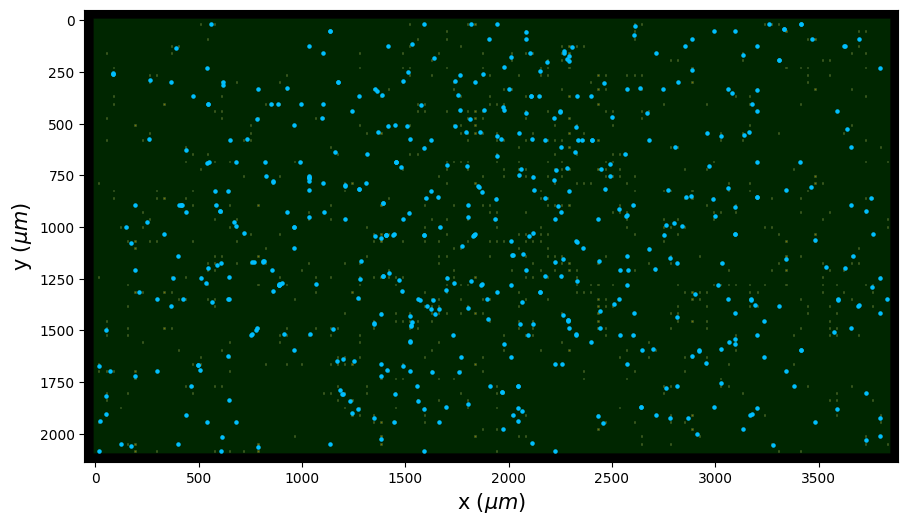

In [14]:

#locations = sp.compute_unit_locations(waveforms)
locations = sp.compute_unit_locations(waveforms)
print(type(locations))

#np.savetxt("unitloc_10mins.txt",locations)
fig,ax = plt.subplots(figsize=(10.5,6.5))
sw.plot_probe_map(recording1,ax=ax,with_channel_ids=False)
ax.set_facecolor('#000000') 
for x,y in locations:
    ax.scatter(x,y, s=5,c='deepskyblue')
ax.invert_yaxis()
plt.savefig(f'/home/mmp/Documents/FolicAcid_T2/M05506_6/unit_locations.svg',format='svg')